# TP 3 — Un petit réseau


## 1) Imports et chargement du dataset

Chargement des modules nécessaires et du dataset Iris, standardisation des features et split en train/test.

In [1]:
import numpy as np  # Bibliothèque pour calculs matriciels et tableaux
import matplotlib.pyplot as plt  # Pour les graphiques
from sklearn.datasets import load_iris  # Dataset Iris (150 fleurs, 4 features, 3 classes)
from sklearn.model_selection import train_test_split  # Découper en train/test
from sklearn.preprocessing import StandardScaler  # Normalisation des données
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Évaluation

# Chargement du dataset Iris
# Chargement du dataset Iris
iris = load_iris()  # Charge les données
X = iris.data  # Features : 4 mesures (longueur/largeur sépales/pétales)
y = iris.target  # Labels : 0, 1, ou 2 (setosa, versicolor, virginica)

# Normalisation : centre les données (moyenne=0, écart-type=1)
scaler = StandardScaler()  # Crée l'objet qui va normaliser
X = scaler.fit_transform(X)  # Calcule moyenne/écart-type ET transforme X

# Découpage en ensemble d'entraînement (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('Train:', X_train.shape, 'Test:', X_test.shape)  # Affiche les dimensions

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Train: (120, 4) Test: (30, 4)


## 2) Initialisation du réseau

Matrices W1, b1, W2, b2

In [2]:
D = X_train.shape[1]  # Nombre de features en entrée (4)
H = 10  # Nombre de neurones dans la couche cachée
C = 3  # Nombre de classes en sortie (3 espèces)

# Initialisation de W1 : matrice (4, 10) (avec Xavier/He initialization possible
# (multiplie par sqrt(2/D) pour éviter vanishing/exploding gradients)
W1 = np.random.randn(D, H) 

# Biais de la couche 1 : vecteur (1, 10) initialisé à zéro
b1 = np.zeros((1, H))

# Initialisation de W2 : matrice (10, 3)
W2 = np.random.randn(H,C)

# Biais de la couche 2 : vecteur (1, 3)
b2 = np.zeros((1,C))

print('Shapes: W1', W1.shape, 'b1', b1.shape, 'W2', W2.shape, 'b2', b2.shape)

Shapes: W1 (4, 10) b1 (1, 10) W2 (10, 3) b2 (1, 3)


## 3) Fonctions utilitaires

Implémentation de `softmax`, `relu`, `relu_deriv`, `cross_entropy_loss`, `accuracy`.

In [3]:
def softmax(Z):
    """Transforme les scores en probabilités (somme = 1)"""
    # Soustrait le max pour stabilité numérique (évite overflow avec exp)
    Z_stable = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(Z_stable)  # Exponentielle de chaque élément
    # Divise par la somme pour avoir des probas qui somment à 1
    probs = expZ / np.sum(expZ, axis=1, keepdims=True)
    return probs

def relu(Z):
    # ⛳ À COMPLETER Met à 0 toutes les valeurs négatives
    return np.maximum(0,Z)

def relu_deriv(Z):
    # ⛳ À COMPLETER Convertit booléen en float
    return (Z > 0).astype(float)

def cross_entropy_loss(probs, y):
    """Calcule la loss (cross-entropy) entre prédictions et vraies classes"""
    N = y.shape[0]  # Nombre d'exemples
    # Prend le log de la proba de la bonne classe pour chaque exemple
    correct_logprobs = -np.log(probs[np.arange(N), y] + 1e-15)
    loss = np.sum(correct_logprobs) / N  # Moyenne sur tous les exemples
    return loss

def accuracy(probs, y):
    """Calcule le pourcentage de bonnes prédictions"""
    preds = np.argmax(probs, axis=1)  # Classe avec la plus haute proba
    return np.mean(preds == y)  # Proportion de prédictions correctes


## 4) Forward pass

La fonction `forward(X, W1, b1, W2, b2)` qui renvoie `(probs, cache)`.

In [4]:
def forward(X, W1, b1, W2, b2):
    # ⛳ À COMPLETER calculer Z1, A1 (utilisation de ReLu), Z2 (utilisation de softmax), probs
    # ⛳ et retourner probs, cache
    Z1 = np.matmul(X,W1) + b1
    A1 = relu(Z1)
    
    Z2 = np.matmul(A1,W2) + b2
    probs = softmax(Z2)
    cache = (X, Z1, A1, Z2)
    
    return probs, cache
    

## 5) Backpropagation

La fonction `backward(probs, cache, y, W2)` retourne `dW1, db1, dW2, db2`.

In [7]:
def backward(probs, cache, y, W2):
    """Passe arrière : calcule les gradients"""
    X, Z1, A1, Z2 = cache  # Récupère les valeurs du forward
    N = X.shape[0]  # Nombre d'exemples
    
    # One-hot encoding : convertit y en vecteur [0,1,0] par exemple
    Y_onehot = np.zeros_like(probs)  # Matrice de zéros (120, 3)
    Y_onehot[np.arange(N), y] = 1.0  # Met 1 à l'indice de la bonne classe

    # Gradient de la couche 2
    dZ2 = probs - Y_onehot  # 💡 Dérivée de softmax + cross-entropy
    dW2 = np.matmul(A1.T, dZ2) / N  # Gradient de W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / N  # Gradient de b2

    # Backprop vers la couche 1
    dA1 = np.matmul(dZ2, W2.T)  # Gradient qui remonte
    dZ1 = dA1 * relu_deriv(Z1)  # Multiplie par dérivée de ReLU
    # ⛳ À COMPLETER dW1 Gradient de W1
    dW1 = np.matmul(X.T, dZ1) / N
    # ⛳ À COMPLETER db1 Gradient de b1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / N
    
    return dW1, db1, dW2, db2


## 6) Entraînement

Boucle d'entraînement avec descente de gradient (batch entier).
Affichage loss/accuracy toutes les 100 epochs.

In [12]:
# hyperparams
lr = 0.05
epochs = 1000
loss_history = []
acc_history = []
# ⛳ À COMPLETER boucle d'entraînement complète
for epoch in range(1, epochs + 1):
    probs, cache = forward(X_train, W1, b1, W2, b2)
    
    loss = cross_entropy_loss(probs, y_train)
    acc = accuracy(probs, y_train)
    loss_history.append(loss)
    acc_history.append(acc)
    
    dW1, db1, dW2, db2 = backward(probs, cache, y_train, W2)
    
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
# A la fin, afficher la loss finale et l'accuracy
print(f"Loss finale après {epochs} epochs : {loss_history[-1]:.4f}")
print(f"Accuracy finale après {epochs} epochs : {acc_history[-1]*100:.2f}%")



Loss finale après 1000 epochs : 0.0413
Accuracy finale après 1000 epochs : 98.33%


## 7) Évaluation

Évaluation sur le set de test, affiche matrice de confusion et courbes.

Test - loss: 0.0138, acc: 100.00%


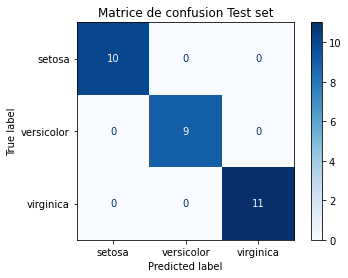

In [18]:
# ⛳ À COMPLETER forward sur X_test, calculer loss et accuracy
probs_test, _ = forward(X_test, W1, b1, W2, b2)
test_loss = cross_entropy_loss(probs_test, y_test)
test_acc = accuracy(probs_test, y_test)
print(f"Test - loss: {test_loss:.4f}, acc: {test_acc*100:.2f}%")

preds = np.argmax(probs_test, axis = 1)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels=iris.target_names).plot(cmap='Blues')
plt.title("Matrice de confusion Test set")
plt.show()
# ⛳ À COMPLETER afficher matrice de confusion
# ⛳ À COMPLETER tracer loss_history et acc_history


## Exercices

1) Remplacer `ReLU` par `tanh` ou `sigmoid` et comparer la convergence.
2) Modifier le `learning rate` et observer les modifications.
3) Ajouter régularisation L2 : ajouter `lambda * W` aux gradients.
4) Implémenter mini-batch SGD (shuffle + batches).

